Lavoro sui dataset iniziali con tutte le etichette

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import TargetEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif

import sys
sys.path.insert(1, '')
from utility import Dataset

train_df = pd.read_csv(f'KDDTrain+.txt', header=None)
test_df = pd.read_csv(f'KDDTest+.txt', header=None)

# train_df = Dataset(train_df)
# test_df = Dataset(test_df)

# Encoding of categorical variables
One hot encoder per 'protocol type' (3 valori) e 'flag' (11 valori) \
Target encoder per 'service' (70 valori) \
ATTENZIONE: se ci dovesse essere overfitting, sostituire Target encoder con Frequency encoder \
oppure fare smoothing o cross-validation (chatGPT spiega come si fa)

In [ ]:
def oh_encoder(train_df, test_df, nominal_features):
    enc = OneHotEncoder()
    train_encoded = enc.fit_transform(train_df[nominal_features]).toarray()
    test_encoded = enc.transform(test_df[nominal_features]).toarray()
    new_columns = []
    for i, feature in enumerate(nominal_features):
        new_columns.extend([f"{feature}_{str(cat)}" for cat in enc.categories_[i]])

    train_ohe = train_df.drop(nominal_features, axis=1)
    train_ohe = pd.concat([train_ohe, pd.DataFrame(train_encoded, columns=new_columns)], axis=1)

    test_ohe = test_df.drop(nominal_features, axis=1)
    test_ohe = pd.concat([test_ohe, pd.DataFrame(test_encoded, columns=new_columns)], axis=1)

    return train_ohe, test_ohe

def t_encoder(train_df, test_df, nominal_features):
    enc = TargetEncoder()
    train_encoded = enc.fit_transform(train_df[nominal_features], train_df['label'])
    test_encoded = enc.transform(test_df[nominal_features])

    train_t = train_df.drop(nominal_features, axis=1)
    train_t = pd.concat([train_t, pd.DataFrame(train_encoded, columns=nominal_features)], axis=1)

    test_t = test_df.drop(nominal_features, axis=1)
    test_t = pd.concat([test_t, pd.DataFrame(test_encoded, columns=nominal_features)], axis=1)

    return train_t, test_t

def l_encoder(train_df, test_df, nominal_features):
    enc = LabelEncoder()
    for feature in nominal_features:
        train_df[feature] = enc.fit_transform(train_df[feature])
        test_df[feature] = enc.transform(test_df[feature])

    return train_df, test_df

train_new = Dataset(train_df).get_label2()
test_new= Dataset(test_df).get_label2()
# train_t, test_t = t_encoder(train_new, test_new, ['service', ])
# train_t, test_t = oh_encoder(train_t, test_t, ['protocol_type', 'flag'])
train_new, test_new = l_encoder(train_new, test_new, ['protocol_type', 'service', 'flag', 'label'])
print(train_new)


# Feature engineering

In [10]:
from sklearn.feature_selection import mutual_info_classif

X_train = train_new.drop(['label'], axis=1)
y_train = train_new['label']
X_test = test_new.drop(['label'], axis=1)
y_test = test_new['label']

mutual_info = mutual_info_classif(X_train, y_train)
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train.columns
mutual_info.sort_values(ascending=False)

src_bytes                      0.565931
service                        0.468481
dst_bytes                      0.441191
same_srv_rate                  0.368641
flag                           0.367457
diff_srv_rate                  0.361676
dst_host_srv_count             0.335442
dst_host_same_srv_rate         0.310934
logged_in                      0.291571
dst_host_serror_rate           0.287302
dst_host_diff_srv_rate         0.283970
dst_host_srv_serror_rate       0.282475
serror_rate                    0.276237
srv_serror_rate                0.268880
count                          0.263573
dst_host_srv_diff_host_rate    0.185248
dst_host_count                 0.145033
dst_host_same_src_port_rate    0.132431
srv_diff_host_rate             0.099158
srv_count                      0.063769
dst_host_srv_rerror_rate       0.060922
protocol_type                  0.056100
rerror_rate                    0.041250
dst_host_rerror_rate           0.037430
srv_rerror_rate                0.035230


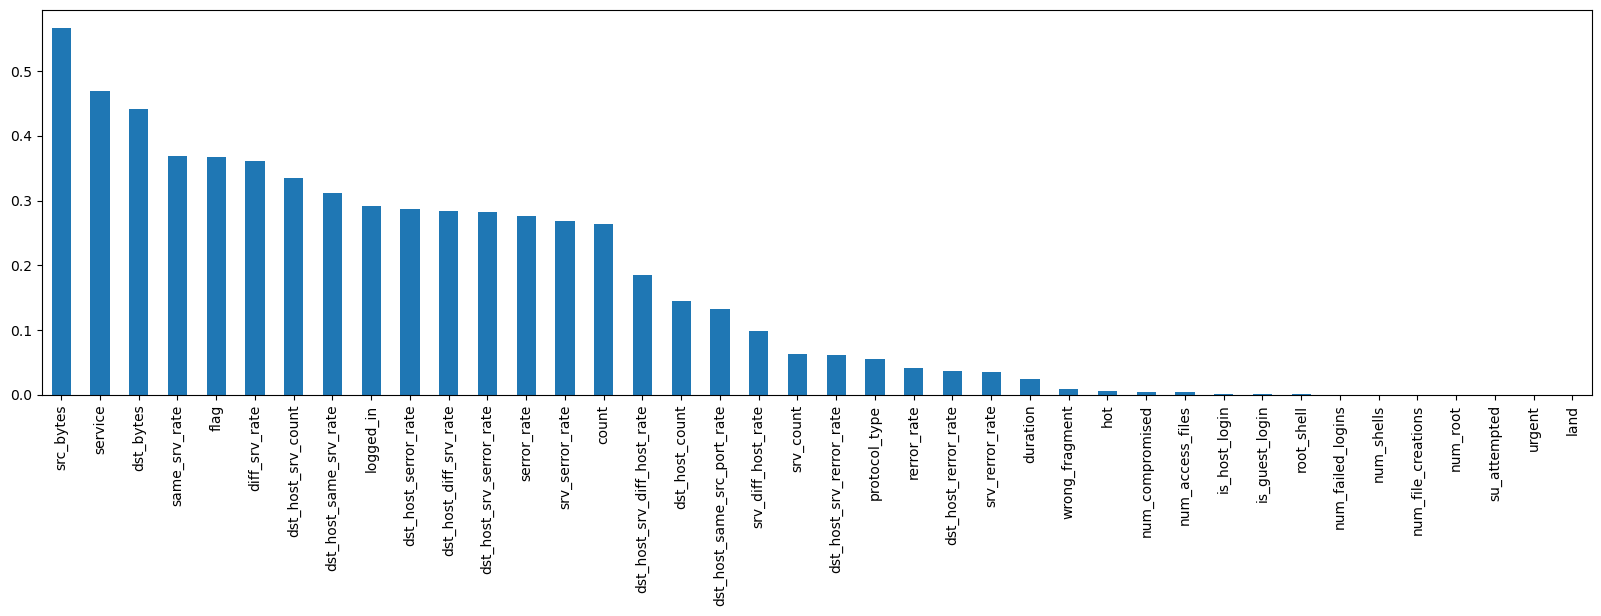

In [11]:
mutual_info.sort_values(ascending=False).plot.bar(figsize=(20, 5));

# Feature selection

In [12]:
from sklearn.feature_selection import SelectKBest
Select_features = SelectKBest(mutual_info_classif, k=30)
Select_features.fit(X_train, y_train)
X_train.columns[Select_features.get_support()]

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'wrong_fragment', 'hot', 'logged_in', 'num_compromised',
       'num_file_creations', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate'],
      dtype='object')

In [13]:
columns=['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'wrong_fragment', 'hot', 'logged_in', 'num_compromised',
       'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate']

#We will continue our model with top 15 features, because dataset is big enough

X_train=X_train[columns]
X_test=X_test[columns]

# Scaling

In [14]:
# Per le feature continue: Se queste seguono o sono vicine a una distribuzione normale, 
# lo StandardScaler è spesso una buona scelta. Se invece ci sono outlier o i dati 
# sono distribuiti in modo non normale, considera RobustScaler o MinMaxScaler. (CONTROLLARE GLI OUTLIERS)
# Per le feature categoriali codificate (come One-Hot Encoded): in generale, 
# non è necessario applicare uno scaler poiché i valori saranno già binari (0 e 1). 
# Tuttavia, se hai usato un encoding come il Target Encoding, potresti voler applicare 
# uno scaler come MinMaxScaler per portare i valori target in un intervallo uniforme.

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

def scaler(train_df, test_df, numeric_features, scaler = MinMaxScaler()):
    train_scaled = scaler.fit_transform(train_df[numeric_features])
    test_scaled = scaler.transform(test_df[numeric_features])

    train_ss = train_df.drop(numeric_features, axis=1)
    train_ss = pd.concat([train_ss, pd.DataFrame(train_scaled, columns=numeric_features)], axis=1)

    test_ss = test_df.drop(numeric_features, axis=1)
    test_ss = pd.concat([test_ss, pd.DataFrame(test_scaled, columns=numeric_features)], axis=1)

    return train_ss, test_ss

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [ ]:
# TEMPORANEO    

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

XGBoost_model = XGBClassifier(random_state = 42)
Logistic_model = LogisticRegression(random_state=42)
RandomForest_model = RandomForestClassifier(random_state=42)
XGBoost = XGBoost_model.fit(X_train,y_train)
Logistic = Logistic_model.fit(X_train,y_train)
RandomForest = RandomForest_model.fit(X_train,y_train)

#it's a helper function in order to evaluate our model if it's overfit or underfit.
def eval_metric(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_pred = model.predict(X_test)
    
    print("Test_Set")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print()
    print("Train_Set")
    print(confusion_matrix(y_train, y_train_pred))
    print(classification_report(y_train, y_train_pred))

eval_metric(Logistic_model, X_train, y_train, X_test, y_test)
eval_metric(XGBoost_model, X_train, y_train, X_test, y_test)
eval_metric(RandomForest_model, X_train, y_train, X_test, y_test)

# Feature Selection 

1. Attribute Ratio

2. Correlation-based Feature Selection (chi-square, mutual information)

3. Information Gain

4. Gain Ratio

5. PCA

6. RFE

7. SFS

8. Variance Threshold ma solo se ho tempo

# 1. Attribute Ratio
Attribute Ratio approach is used for feature selection purposes. This approach was described by Hee-su Chae and Sang Hyun Choi in Feature Selection for efficient Intrusion Detection using Attribute Ratio and Feature Selection for Intrusion Detection using NSL-KDD

This approach is also used for nominal variables as they were encoded as binary variables above.

As it is a possible to have 'null' values because binary features could have Frequency(0) = 0, those 'null' values are replaced with 1000.0 (magic number). For NSL KDD dataset it is related only for 'protocol_type_tcp' ohe variable.

In section 4, we explain NSL-KDD data which has three attribute types. We use attribute average and frequency for each class calculate the AR from numeric and binary type. AR can be calculated as :                             (7)   Class Ratio (CR) is attribute is ratio of each class for Attribute i. CR is calculated by two methods according to the type of attributes. CR can be calculated as for numeric :                                      (8)  CR can be calculated as for binary : 

After calculating AR(i), Features rank ordering larger AR. Table 4 shows the rank of features with a calculated AR. 

In [80]:
# ho calcolato l'attribute ratio per ogni feature (divisione in 5 classi)
train_5_df = Dataset(train_df).get_label5()

def attributeRatio(feature, dataset):
    class_ratio = {}

    if feature in nominal_features:
        return 0

    if feature in binary_features:
        for label in dataset['label'].unique():
            class_ones = dataset[dataset['label'] == label][feature].sum()
            class_zeros = dataset[dataset['label'] == label][feature].count() - class_ones
            class_ratio[label] = class_ones / class_zeros
    else:
        total_mean = dataset[feature].mean()
        for label in dataset['label'].unique():
            class_mean = dataset[dataset['label'] == label][feature].mean()
            class_ratio[label] = class_mean / total_mean
    return max(class_ratio.values())

# calcola l'attribute ratio per ogni feature tranne 'label' e 'score'
attribute_ratios = {}
for feature in train_5_df.columns:
    if feature not in ['label', 'score', 'num_outbound_cmds']:
        attribute_ratios[feature] = attributeRatio(feature, train_5_df)

# ordina le feature in base all'attribute ratio
sorted_attribute_ratios = sorted(attribute_ratios.items(), key=lambda x: x[1], reverse=True)
# stampa una tabella con le feature ordinate. la prima colonna è il rank, la seconda la feature e la terza l'attribute ratio
for i, (feature, ratio) in enumerate(sorted_attribute_ratios):
    print(f"{i+1} & {feature} & {ratio:.2f} \\\\")


1 & num_shells & 326.11 \\
2 & urgent & 173.04 \\
3 & num_file_creations & 62.23 \\
4 & num_failed_logins & 46.04 \\
5 & hot & 40.77 \\
6 & logged_in & 10.57 \\
7 & dst_bytes & 9.15 \\
8 & src_bytes & 8.46 \\
9 & duration & 7.23 \\
10 & dst_host_srv_diff_host_rate & 5.76 \\
11 & dst_host_diff_srv_rate & 4.84 \\
12 & num_access_files & 4.69 \\
13 & dst_host_same_src_port_rate & 4.39 \\
14 & num_compromised & 4.34 \\
15 & diff_srv_rate & 4.07 \\
16 & dst_host_srv_rerror_rate & 3.67 \\
17 & srv_rerror_rate & 3.67 \\
18 & rerror_rate & 3.65 \\
19 & dst_host_rerror_rate & 3.28 \\
20 & srv_diff_host_rate & 3.08 \\
21 & wrong_fragment & 2.74 \\
22 & dst_host_srv_serror_rate & 2.67 \\
23 & srv_serror_rate & 2.64 \\
24 & serror_rate & 2.63 \\
25 & dst_host_serror_rate & 2.63 \\
26 & num_root & 2.61 \\
27 & count & 2.12 \\
28 & dst_host_srv_count & 1.65 \\
29 & dst_host_same_srv_rate & 1.56 \\
30 & same_srv_rate & 1.51 \\
31 & dst_host_count & 1.34 \\
32 & srv_count & 1.18 \\
33 & root_shell & 1

# 2. Correlation-based Feature Selection
https://medium.com/@sariq16/correlation-based-feature-selection-in-a-data-science-project-3ca08d2af5c6

seleziona le k feature più rilevanti secondo il chi2 (hanno alta correlazione con il label e bassa con le altre feature), ANOVA F-test, Mutual Information.

In [12]:
def get_best_features(train_data, test_data, score_func, k):
    X = train_data.drop(['label', 'score'], axis=1)
    y = train_data['label']
    selector = SelectKBest(score_func=score_func, k = k).fit(X, y)
    X_train_selected = selector.transform(X)
    X_test_selected = selector.transform(test_data.drop(['label', 'score'], axis=1))
    return X_train_selected, X_test_selected


train_new = Dataset(train_df).get_label2()
test_new= Dataset(test_df).get_label2()
train_t, test_t = t_encoder(train_new, test_new, ['service', ])
train_t, test_t = oh_encoder(train_t, test_t, ['protocol_type', 'flag'])

train_reduced, test_reduced = get_best_features(train_t, test_t, f_classif, 10)
print(train_reduced.shape)
train_reduced, test_reduced = get_best_features(train_t, test_t, chi2, 10)
print(train_reduced.shape)
train_reduced, test_reduced = get_best_features(train_t, test_t, mutual_info_classif, 10)
print(train_reduced.shape)




(125973, 10)
(125973, 10)
(125973, 10)


# 3. Wrapper Methods

Questi metodi iterano attraverso le combinazioni di feature e valutano la loro importanza usando un modello predittivo.

Recursive Feature Elimination (RFE): Utilizza un modello per selezionare feature rilevanti, eliminando quelle meno importanti ad ogni iterazione. Funziona bene con modelli come SVM, alberi decisionali o regressioni logistiche.

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

train_new = Dataset(train_df).get_label2()
test_new= Dataset(test_df).get_label2()
train_rfe, test_rfe = t_encoder(train_new, test_new, ['service', ])
train_rfe, test_rfe = oh_encoder(train_rfe, test_rfe, ['protocol_type', 'flag'])

X_train_rfe = train_rfe.drop(['label', 'score'], axis=1)
y_train_rfe = train_rfe['label']
X_test_rfe = test_rfe.drop(['label', 'score'], axis=1)
y_test_rfe = test_rfe['label']

model = RandomForestClassifier()
rfe = RFE(model, n_features_to_select=10).fit(X_train_rfe, y_train_rfe)
X_train_rfe_selected = rfe.transform(X_train_rfe)
X_test_rfe_selected = rfe.transform(X_test_rfe)


Sequential Feature Selection (SFS): Aggiunge o rimuove feature in modo sequenziale, valutando il modello in ogni passaggio.

In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)

train_new = Dataset(train_df).get_label2()
test_new= Dataset(test_df).get_label2()
train_sfs, test_sfs = t_encoder(train_new, test_new, ['service', ])
train_sfs, test_sfs = oh_encoder(train_sfs, test_sfs, ['protocol_type', 'flag'])

X_train_sfs = train_sfs.drop(['label', 'score'], axis=1)
y_train_sfs = train_sfs['label']
X_test_sfs = test_sfs.drop(['label', 'score'], axis=1)

model = RandomForestClassifier()
sfs = SequentialFeatureSelector(model, 
                                cv = skf,
                                scoring = 'accuracy', 
                                direction='forward', 
                                n_features_to_select=10).fit(X_train_rfe, y_train_rfe)
X_train_sfs_selected = sfs.transform(X_train_sfs)
X_test_sfs_selected = sfs.transform(X_test_sfs)


In [ ]:
# calcola information gain 
def get_information_gain(dataset, feature):
    entropy = 0
    for label in dataset['label'].unique():
        p = dataset[dataset['label'] == label][feature].sum() / dataset[feature].sum()
        entropy += p * np.log2(p)
    return entropy

information_gains = {}
for feature in train_5_df.columns:
    if feature not in ['label', 'score', 'num_outbound_cmds']:
        information_gains[feature] = get_information_gain(train_5_df, feature)

# ordina le feature in base all'information gain
sorted_information_gains = sorted(information_gains.items(), key=lambda x: x[1], reverse=True)
# stampa una tabella con le feature ordinate. la prima colonna è il rank, la seconda la feature e la terza l'information gain
for i, (feature, gain) in enumerate(sorted_information_gains):
    print(f"{i+1} & {feature} & {gain:.2f} \\\\")


# calcola gain ratio
def get_gain_ratio(dataset, feature):
    split_info = 0
    for label in dataset['label'].unique():
        p = dataset[dataset['label'] == label][feature].sum() / dataset[feature].sum()
        split_info += p * np.log2(p)
    split_info = -split_info
    return information_gains[feature] / split_info

gain_ratios = {}
for feature in train_5_df.columns:
    if feature not in ['label', 'score', 'num_outbound_cmds']:
        gain_ratios[feature] = get_gain_ratio(train_5_df, feature)

# ordina le feature in base al gain ratio
sorted_gain_ratios = sorted(gain_ratios.items(), key=lambda x: x[1], reverse=True)
# stampa una tabella con le feature ordinate. la prima colonna è il rank, la seconda la feature e la terza il gain ratio
for i, (feature, ratio) in enumerate(sorted_gain_ratios):
    print(f"{i+1} & {feature} & {ratio:.2f} \\\\")



# 4. PCA

In [ ]:
from sklearn.decomposition import PCA

train_new = Dataset(train_df).get_label2()
X_train_pca = train_new.drop(['label', 'score'], axis=1)
y_train_pca = train_new['label']
X_test_pca = test_df.drop(['label', 'score'], axis=1)

pca = PCA(n_components='mle')
X_train_pca = pca.fit_transform(X_train_pca)
X_test_pca = pca.transform(X_test_pca)
print(X_train_pca.shape)
print(pca.components_)
print(pca.explained_variance_ratio_)
print(pca.explained_variance_)
print(pca.singular_variance_ratio_.sum()*100)

# 5.Discretization

In [ ]:
from sklearn.preprocessing import KBinsDiscretizer

discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
X_discretized = discretizer.fit_transform(X_train_pca)